<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b> DM-45218-Refactoring diaPipe </b><br>
Notebook comparing original diaPipe to refactored diaPipe which includes five new methods and timings. <br> <br>

Contact author: Audrey Budlong <br>
Last verified to run: 15 September 2024 <br>
LSST Science Pipelines version: <code>d_2024_09_11</code> <br>
Additional notes: run with a local ap_verfify run of <code>ap_verify_ci_hits2015</code> <br>

## Run details

Baseline run used <code>d_2024_09_11</code>.

### Table of Contents

1. Main package imports
2. Configuring data access
3. Analysis of Sources
   * Number of DiaSources & DiaObjects
   * APBD Source Comparison
   * Comparison Between Runs of PSF & Science Fluxes
4. Flags
5. Reliability Comparison
6. Plot of All DiaSources
7. Number of "Good" DiaSources per Detector

### 1. Main package imports

In [1]:
import lsst.afw.display as afwDisplay
import lsst.geom as geom
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from astropy.table import Table
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
from lsst.afw.image import MultibandExposure
from lsst.analysis.ap import apdb, nb_utils
from lsst.daf.butler import Butler
from sqlalchemy import select, func

# import lsst.analysis.ap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 2. Configuring data access

In [2]:
repo = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11/repo/butler.yaml'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = Butler(repo, collections=collections)

dbType = 'sqlite'
dbName = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11/association.db'

reader = apdb.ApdbSqliteQuery(dbName, instrument=instrument)

In [3]:
len(reader._tables)

6

In [4]:
default_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [5]:
default_run['run_name'] = 'Main'

In [6]:
list(butler.registry.queryDatasets("goodSeeingDiff_diaForcedSrc"))

[DatasetRef(DatasetType('goodSeeingDiff_diaForcedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'DECam', detector: 60, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20240916T061126Z', id=4d47593c-12ba-4cc6-a029-d25b8bd7f6c8),
 DatasetRef(DatasetType('goodSeeingDiff_diaForcedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'DECam', detector: 56, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20240916T061126Z', id=6eb86fbb-ecb0-4082-8d36-a15dc28aff83),
 DatasetRef(DatasetType('goodSeeingDiff_diaForcedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'DECam', detector: 5, visit: 411420, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20240916T061126Z',

In [7]:
diaForcedSrc_mainRef = list(butler.registry.queryDatasets("goodSeeingDiff_diaForcedSrc"))
print(f'Number of Dataset References: {len(diaForcedSrc_mainRef)}')

Number of Dataset References: 6


In [8]:
dataId0 = diaForcedSrc_mainRef[0].dataId
dataId1 = diaForcedSrc_mainRef[1].dataId
dataId2 = diaForcedSrc_mainRef[2].dataId
dataId3 = diaForcedSrc_mainRef[3].dataId
dataId4 = diaForcedSrc_mainRef[4].dataId
dataId5 = diaForcedSrc_mainRef[5].dataId

In [9]:
catalog0 = butler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId0)
catalog1 = butler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId1)
catalog2 = butler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId2)
catalog3 = butler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId3)
catalog4 = butler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId4)
catalog5 = butler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId5)

#### DM—45218 diaPipe Refactoring Changes Dataset

In [10]:
testrepo = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11-DM45218/repo/butler.yaml'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

testbutler = Butler(testrepo, collections=collections)

dbType = 'sqlite'
testdbName = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11-DM45218/association.db'

reader = apdb.ApdbSqliteQuery(testdbName, instrument='DECam')

In [11]:
len(reader._tables)

6

In [12]:
test_run = {
    'repo': testrepo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': testbutler,
    'dbType': dbType,
    'dbName': testdbName,
    'reader': reader
}

In [13]:
test_run['run_name'] = 'Refactoring diaPipe'

In [14]:
list(testbutler.registry.queryDatasets("goodSeeingDiff_diaForcedSrc"))

[DatasetRef(DatasetType('goodSeeingDiff_diaForcedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'DECam', detector: 60, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20240916T070337Z', id=9ddab59d-ff84-464c-ac60-63ae2c9f863b),
 DatasetRef(DatasetType('goodSeeingDiff_diaForcedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'DECam', detector: 56, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20240916T070337Z', id=cb2616e1-26b2-4831-8863-184d154d2ed1),
 DatasetRef(DatasetType('goodSeeingDiff_diaForcedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'DECam', detector: 5, visit: 411420, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20240916T070337Z',

In [15]:
diaForcedSrc_testRef = list(testbutler.registry.queryDatasets("goodSeeingDiff_diaForcedSrc"))
print(f'Number of Dataset References: {len(diaForcedSrc_testRef)}')

Number of Dataset References: 6


In [16]:
dataId0_test = diaForcedSrc_testRef[0].dataId
dataId1_test = diaForcedSrc_testRef[1].dataId
dataId2_test = diaForcedSrc_testRef[2].dataId
dataId3_test = diaForcedSrc_testRef[3].dataId
dataId4_test = diaForcedSrc_testRef[4].dataId
dataId5_test = diaForcedSrc_testRef[5].dataId

In [17]:
catalog0_test = testbutler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId0_test)
catalog1_test = testbutler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId1_test)
catalog2_test = testbutler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId2_test)
catalog3_test = testbutler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId3_test)
catalog4_test = testbutler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId4_test)
catalog5_test = testbutler.get("goodSeeingDiff_diaForcedSrc", dataId=dataId5_test)

## 3. Analysis of Sources

### a. Number of DiaSources & DiaObjects

In [18]:
default_run['robjTable'] = default_run['reader'].load_objects()
default_run['rsrcTable'] = default_run['reader'].load_sources()

In [19]:
test_run['robjTable'] = test_run['reader'].load_objects()
test_run['rsrcTable'] = test_run['reader'].load_sources()

In [20]:
# number of objects
n_objs = pd.DataFrame()

In [21]:
n_objs.loc['Main', 'n_rdiasrc'] = len(default_run['rsrcTable'])
n_objs.loc['Refactoring diaPipe', 'n_rdiasrc'] = len(test_run['rsrcTable'])

In [22]:
n_objs.loc['Main', 'n_rdiaobj'] = len(default_run['robjTable'])
n_objs.loc['Refactoring diaPipe', 'n_rdiaobj'] = len(test_run['robjTable'])

In [23]:
n_objs

,n_rdiasrc,n_rdiaobj
Main,845.0,845.0
Refactoring diaPipe,845.0,845.0


### b. APBD Source Comparison

In [24]:
association1 = apdb.ApdbSqliteQuery('/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11/association.db', instrument=instrument)
association2 = apdb.ApdbSqliteQuery('/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11-DM45218/association.db', instrument=instrument)

butler1 = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11/repo/butler.yaml'
butler2 = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11-DM45218/repo/butler.yaml'

unique1, unique2, matched = nb_utils.compare_sources(butler1, butler2, association1, association2, match_radius=0.01)

789 matched sources; 0 unique to set 1; 4 unique to set 2.


In [25]:
unique2

,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,dec,decErr,ra_dec_Cov,x,xErr,y,yErr,x_y_Cov,centroid_flag,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,snr,psfFlux,psfFluxErr,psfRa,psfRaErr,psfDec,psfDecErr,psfFlux_psfRa_Cov,psfFlux_psfDec_Cov,psfRa_psfDec_Cov,psfLnL,psfChi2,psfNdata,psfFlux_flag,psfFlux_flag_edge,psfFlux_flag_noGoodPixels,trailFlux,trailFluxErr,trailRa,trailRaErr,trailDec,trailDecErr,trailLength,trailLengthErr,trailAngle,trailAngleErr,trailFlux_trailRa_Cov,trailFlux_trailDec_Cov,trailFlux_trailLength_Cov,trailFlux_trailAngle_Cov,trailRa_trailDec_Cov,trailRa_trailLength_Cov,trailRa_trailAngle_Cov,trailDec_trailLength_Cov,trailDec_trailAngle_Cov,trailLength_trailAngle_Cov,trailLnL,trailChi2,trailNdata,trail_flag_edge,dipoleMeanFlux,dipoleMeanFluxErr,dipoleFluxDiff,dipoleFluxDiffErr,dipoleRa,dipoleRaErr,dipoleDec,dipoleDecErr,dipoleLength,dipoleLengthErr,dipoleAngle,dipoleAngleErr,dipoleMeanFlux_dipoleFluxDiff_Cov,dipoleMeanFlux_dipoleRa_Cov,dipoleMeanFlux_dipoleDec_Cov,dipoleMeanFlux_dipoleLength_Cov,dipoleMeanFlux_dipoleAngle_Cov,dipoleFluxDiff_dipoleRa_Cov,dipoleFluxDiff_dipoleDec_Cov,dipoleFluxDiff_dipoleLength_Cov,dipoleFluxDiff_dipoleAngle_Cov,dipoleRa_dipoleDec_Cov,dipoleRa_dipoleLength_Cov,dipoleRa_dipoleAngle_Cov,dipoleDec_dipoleLength_Cov,dipoleDec_dipoleAngle_Cov,dipoleLength_dipoleAngle_Cov,dipoleLnL,dipoleChi2,dipoleNdata,scienceFlux,scienceFluxErr,forced_PsfFlux_flag,forced_PsfFlux_flag_edge,forced_PsfFlux_flag_noGoodPixels,snapDiffFlux,snapDiffFluxErr,fpBkgd,fpBkgdErr,ixx,ixxErr,iyy,iyyErr,ixy,ixyErr,ixx_iyy_Cov,ixx_ixy_Cov,iyy_ixy_Cov,ixxPSF,iyyPSF,ixyPSF,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,band,isDipole,time_processed,time_withdrawn,bboxSize,pixelFlags,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_offimage,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,pixelId,instrument
3,88341369835225098,411371,56,88341369835225098,0,0,None,57071.227994,154.855786,NaN,-5.623523,NaN,NaN,169.0,NaN,62.0,NaN,None,True,-6737.123047,489.116272,True,False,5.664283,-722.165405,122.223068,None,None,None,None,None,None,None,None,2575.927246,1681,True,False,False,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,0,False,NaN,NaN,NaN,NaN,None,None,None,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,0,73.583092,111.182404,True,False,False,None,None,None,None,NaN,None,NaN,None,NaN,None,None,None,None,0.140768,-0.008084,-0.008084,True,False,False,False,None,0.000421,g,False,2024-09-16 07:23:42.028,None,18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,10563326287281,DECam
197,88341369835225344,411371,56,88341369835225344,0,0,None,57071.227994,155.112760,NaN,-5.731866,NaN,NaN,1644.0,NaN,3565.0,NaN,None,True,-1851.624512,477.542938,True,False,10.344364,-1254.276123,122.896065,None,None,None,None,None,None,None,None,1769.164307,1681,True,False,False,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,0,False,NaN,NaN,NaN,NaN,None,None,None,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,0,-1.047529,109.806404,True,False,False,None,None,None,None,0.136825,None,0.533117,None,0.065507,None,None,None,None,0.140887,-0.008091,-0.008091,True,False,False,False,None,0.000232,g,False,2024-09-16 07:23:42.028,None,18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1056327903739

In [26]:
test1, test2, matchedTest = nb_utils.compare_sources(butler1, butler1, association1, association1, match_radius=0.01)

789 matched sources; 0 unique to set 1; 4 unique to set 2.


In [27]:
test2

,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,dec,decErr,ra_dec_Cov,x,xErr,y,yErr,x_y_Cov,centroid_flag,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,snr,psfFlux,psfFluxErr,psfRa,psfRaErr,psfDec,psfDecErr,psfFlux_psfRa_Cov,psfFlux_psfDec_Cov,psfRa_psfDec_Cov,psfLnL,psfChi2,psfNdata,psfFlux_flag,psfFlux_flag_edge,psfFlux_flag_noGoodPixels,trailFlux,trailFluxErr,trailRa,trailRaErr,trailDec,trailDecErr,trailLength,trailLengthErr,trailAngle,trailAngleErr,trailFlux_trailRa_Cov,trailFlux_trailDec_Cov,trailFlux_trailLength_Cov,trailFlux_trailAngle_Cov,trailRa_trailDec_Cov,trailRa_trailLength_Cov,trailRa_trailAngle_Cov,trailDec_trailLength_Cov,trailDec_trailAngle_Cov,trailLength_trailAngle_Cov,trailLnL,trailChi2,trailNdata,trail_flag_edge,dipoleMeanFlux,dipoleMeanFluxErr,dipoleFluxDiff,dipoleFluxDiffErr,dipoleRa,dipoleRaErr,dipoleDec,dipoleDecErr,dipoleLength,dipoleLengthErr,dipoleAngle,dipoleAngleErr,dipoleMeanFlux_dipoleFluxDiff_Cov,dipoleMeanFlux_dipoleRa_Cov,dipoleMeanFlux_dipoleDec_Cov,dipoleMeanFlux_dipoleLength_Cov,dipoleMeanFlux_dipoleAngle_Cov,dipoleFluxDiff_dipoleRa_Cov,dipoleFluxDiff_dipoleDec_Cov,dipoleFluxDiff_dipoleLength_Cov,dipoleFluxDiff_dipoleAngle_Cov,dipoleRa_dipoleDec_Cov,dipoleRa_dipoleLength_Cov,dipoleRa_dipoleAngle_Cov,dipoleDec_dipoleLength_Cov,dipoleDec_dipoleAngle_Cov,dipoleLength_dipoleAngle_Cov,dipoleLnL,dipoleChi2,dipoleNdata,scienceFlux,scienceFluxErr,forced_PsfFlux_flag,forced_PsfFlux_flag_edge,forced_PsfFlux_flag_noGoodPixels,snapDiffFlux,snapDiffFluxErr,fpBkgd,fpBkgdErr,ixx,ixxErr,iyy,iyyErr,ixy,ixyErr,ixx_iyy_Cov,ixx_ixy_Cov,iyy_ixy_Cov,ixxPSF,iyyPSF,ixyPSF,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,band,isDipole,time_processed,time_withdrawn,bboxSize,pixelFlags,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_offimage,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,pixelId,instrument
3,88341369835225098,411371,56,88341369835225098,0,0,None,57071.227994,154.855786,NaN,-5.623523,NaN,NaN,169.0,NaN,62.0,NaN,None,True,-6737.123047,489.116272,True,False,5.664283,-722.165405,122.223068,None,None,None,None,None,None,None,None,2575.927246,1681,True,False,False,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,0,False,NaN,NaN,NaN,NaN,None,None,None,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,0,73.583092,111.182404,True,False,False,None,None,None,None,NaN,None,NaN,None,NaN,None,None,None,None,0.140768,-0.008084,-0.008084,True,False,False,False,None,0.000421,g,False,2024-09-16 06:28:45.509,None,18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,10563326287281,DECam
197,88341369835225344,411371,56,88341369835225344,0,0,None,57071.227994,155.112760,NaN,-5.731866,NaN,NaN,1644.0,NaN,3565.0,NaN,None,True,-1851.624512,477.542938,True,False,10.344364,-1254.276123,122.896065,None,None,None,None,None,None,None,None,1769.164307,1681,True,False,False,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,0,False,NaN,NaN,NaN,NaN,None,None,None,None,NaN,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,0,-1.047529,109.806404,True,False,False,None,None,None,None,0.136825,None,0.533117,None,0.065507,None,None,None,None,0.140887,-0.008091,-0.008091,True,False,False,False,None,0.000232,g,False,2024-09-16 06:28:45.509,None,18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1056327903739

In [28]:
unique2 == test2

,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,dec,decErr,ra_dec_Cov,x,xErr,y,yErr,x_y_Cov,centroid_flag,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,snr,psfFlux,psfFluxErr,psfRa,psfRaErr,psfDec,psfDecErr,psfFlux_psfRa_Cov,psfFlux_psfDec_Cov,psfRa_psfDec_Cov,psfLnL,psfChi2,psfNdata,psfFlux_flag,psfFlux_flag_edge,psfFlux_flag_noGoodPixels,trailFlux,trailFluxErr,trailRa,trailRaErr,trailDec,trailDecErr,trailLength,trailLengthErr,trailAngle,trailAngleErr,trailFlux_trailRa_Cov,trailFlux_trailDec_Cov,trailFlux_trailLength_Cov,trailFlux_trailAngle_Cov,trailRa_trailDec_Cov,trailRa_trailLength_Cov,trailRa_trailAngle_Cov,trailDec_trailLength_Cov,trailDec_trailAngle_Cov,trailLength_trailAngle_Cov,trailLnL,trailChi2,trailNdata,trail_flag_edge,dipoleMeanFlux,dipoleMeanFluxErr,dipoleFluxDiff,dipoleFluxDiffErr,dipoleRa,dipoleRaErr,dipoleDec,dipoleDecErr,dipoleLength,dipoleLengthErr,dipoleAngle,dipoleAngleErr,dipoleMeanFlux_dipoleFluxDiff_Cov,dipoleMeanFlux_dipoleRa_Cov,dipoleMeanFlux_dipoleDec_Cov,dipoleMeanFlux_dipoleLength_Cov,dipoleMeanFlux_dipoleAngle_Cov,dipoleFluxDiff_dipoleRa_Cov,dipoleFluxDiff_dipoleDec_Cov,dipoleFluxDiff_dipoleLength_Cov,dipoleFluxDiff_dipoleAngle_Cov,dipoleRa_dipoleDec_Cov,dipoleRa_dipoleLength_Cov,dipoleRa_dipoleAngle_Cov,dipoleDec_dipoleLength_Cov,dipoleDec_dipoleAngle_Cov,dipoleLength_dipoleAngle_Cov,dipoleLnL,dipoleChi2,dipoleNdata,scienceFlux,scienceFluxErr,forced_PsfFlux_flag,forced_PsfFlux_flag_edge,forced_PsfFlux_flag_noGoodPixels,snapDiffFlux,snapDiffFluxErr,fpBkgd,fpBkgdErr,ixx,ixxErr,iyy,iyyErr,ixy,ixyErr,ixx_iyy_Cov,ixx_ixy_Cov,iyy_ixy_Cov,ixxPSF,iyyPSF,ixyPSF,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,band,isDipole,time_processed,time_withdrawn,bboxSize,pixelFlags,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_offimage,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,pixelId,instrument
3,True,True,True,True,True,True,False,True,True,False,True,False,False,True,False,True,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
197,True,True,True,True,True,True,False,True,True,False,True,False,False,True,False,True,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,True,False,True,False,True,False,False,False,False,True,True,True,True,True,True,True,False,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
225,True,True,True,True,True,True,False,True,True,False,True,False,False,True,False,True,False,False,True,True,True,Tru

### c. Comparison Between Runs of PSF & Science Fluxes

In [29]:
mainDataIds = [dataId0, dataId1, dataId2, dataId3, dataId4, dataId5]

testDataIds = [dataId0_test, dataId1_test, dataId2_test, dataId3_test, dataId4_test, dataId5_test]

In [30]:
mainCatalogs = [catalog0, catalog1, catalog2, catalog3, catalog4, catalog5]

testCatalogs = [catalog0_test, catalog1_test, catalog2_test, catalog3_test, catalog4_test, catalog5_test]

In [31]:
for mainId, testId, mainCat, testCat in zip (mainDataIds, testDataIds, mainCatalogs, testCatalogs):
    if mainId==testId:
        if (mainCat.psfFlux==testCat.psfFlux).all() and (mainCat.scienceFlux==testCat.scienceFlux).all():
            print(f'PSF and science fluxes the same for {mainId}.')
        if (mainCat.scienceFlux!=testCat.scienceFlux).any():
            print(f'Science fluxes are different for {mainId}.')
        if (mainCat.psfFlux!=testCat.psfFlux).any():
            print(f'PSF fluxes are different for {mainId}.')
        print('\n')
    else:
        print(f'Main {main} is not the same reference ID as the refactored test.')

PSF and science fluxes the same for {instrument: 'DECam', detector: 60, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}.


PSF and science fluxes the same for {instrument: 'DECam', detector: 56, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}.


PSF and science fluxes the same for {instrument: 'DECam', detector: 5, visit: 411420, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}.


PSF and science fluxes the same for {instrument: 'DECam', detector: 10, visit: 411420, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}.


PSF and science fluxes the same for {instrument: 'DECam', detector: 5, visit: 419802, band: 'g', day_obs: 20150308, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}.


PSF and science fluxes the same for {instrument: 'DECam', detector: 10, visit: 419802, band: 'g', day_obs: 20150308, physical_filter: 'g 

In [32]:
for mainId, testId, mainCat, testCat in zip (mainDataIds, testDataIds, mainCatalogs, testCatalogs):
    print(mainId)
    print(f'PSF Flux is the same between runs: {(mainCat.psfFlux==testCat.psfFlux).all()}')
    print(f'Science Flux is the same between runs: {(mainCat.scienceFlux==testCat.scienceFlux).all()}')
    print('\n')

{instrument: 'DECam', detector: 60, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}
PSF Flux is the same between runs: True
Science Flux is the same between runs: True


{instrument: 'DECam', detector: 56, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}
PSF Flux is the same between runs: True
Science Flux is the same between runs: True


{instrument: 'DECam', detector: 5, visit: 411420, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}
PSF Flux is the same between runs: True
Science Flux is the same between runs: True


{instrument: 'DECam', detector: 10, visit: 411420, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}
PSF Flux is the same between runs: True
Science Flux is the same between runs: True


{instrument: 'DECam', detector: 5, visit: 419802, band: 'g', day_obs: 20150308, physical_filter: 'g DECam SDSS c0001 4720

## 4. Flags

In [33]:
badFlagList = [
    "pixelFlags_bad",
    "pixelFlags_crCenter",
    "pixelFlags_interpolatedCenter",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspectCenter",
    "pixelFlags_streakCenter",
    "pixelFlags_injectedCenter",
    "pixelFlags_injected_templateCenter"
    ]

In [34]:
originalTable = default_run['rsrcTable']
refactoredTable = test_run['rsrcTable']

def flagComparison(sourceDataFrame):
    pfBad = sourceDataFrame.pixelFlags_bad.value_counts()
    pfCrCenter = sourceDataFrame.pixelFlags_crCenter.value_counts()
    pfInterpCenter = sourceDataFrame.pixelFlags_interpolatedCenter.value_counts()
    pfSatCenter = sourceDataFrame.pixelFlags_saturatedCenter.value_counts()
    pfSusCenter = sourceDataFrame.pixelFlags_suspectCenter.value_counts()
    pfInjCenter = sourceDataFrame.pixelFlags_streakCenter.value_counts()
    pfInjTempCenter = sourceDataFrame.pixelFlags_injectedCenter.value_counts()
    pfInjTempCentRemoved = sourceDataFrame.pixelFlags_injected_templateCenter.value_counts()
    
    flagData = {"pixelFlags_bad": pfBad, "pixelFlags_crCenter": pfCrCenter, "pixelFlags_interpolatedCenter": pfInterpCenter, \
               "pixelFlags_saturatedCenter": pfSatCenter, "pixelFlags_suspectCenter": pfSusCenter, "pixelFlags_streakCenter": pfInjCenter, \
               "pixelFlags_injectedCenter": pfInjTempCenter, "pixelFlags_injected_templateCenter": pfInjTempCentRemoved}
    
    flagDF = pd.DataFrame(flagData)
    return flagDF


In [35]:
originalFlags = flagComparison(originalTable)
originalFlags

,pixelFlags_bad,pixelFlags_crCenter,pixelFlags_interpolatedCenter,pixelFlags_saturatedCenter,pixelFlags_suspectCenter,pixelFlags_streakCenter,pixelFlags_injectedCenter,pixelFlags_injected_templateCenter
False,837,845.0,845.0,845.0,822,845.0,845.0,845.0
True,8,NaN,NaN,NaN,23,NaN,NaN,NaN


In [36]:
refactoredFlags = flagComparison(refactoredTable)
refactoredFlags

,pixelFlags_bad,pixelFlags_crCenter,pixelFlags_interpolatedCenter,pixelFlags_saturatedCenter,pixelFlags_suspectCenter,pixelFlags_streakCenter,pixelFlags_injectedCenter,pixelFlags_injected_templateCenter
False,837,845.0,845.0,845.0,822,845.0,845.0,845.0
True,8,NaN,NaN,NaN,23,NaN,NaN,NaN


## 5. Reliability Check

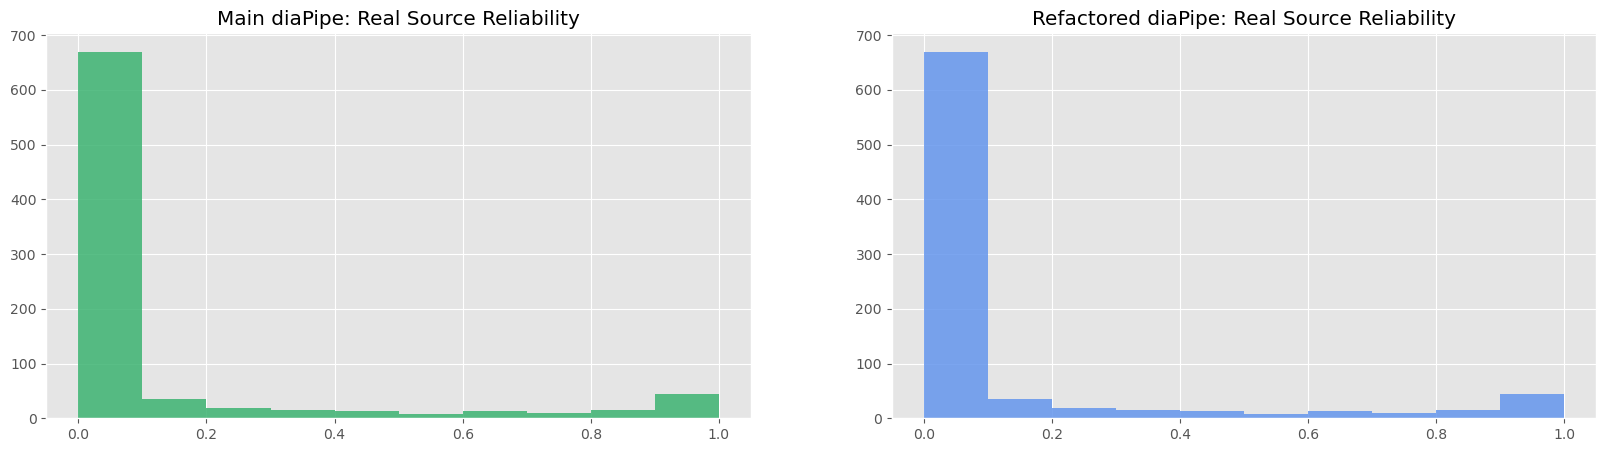

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
default_hist = ax[0].hist(default_run['rsrcTable']['reliability'], color='mediumseagreen', alpha=0.85)
ax[0].set_title('Main diaPipe: Real Source Reliability')
test_hist = ax[1].hist(test_run['rsrcTable']['reliability'], color='cornflowerblue', alpha=0.85)
ax[1].set_title('Refactored diaPipe: Real Source Reliability');

In [38]:
reliability_table = pd.DataFrame()

In [39]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [40]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]

In [41]:
reliability_table

,reliability,Main,Refactoring diaPipe
0,0.0,670.0,670.0
1,0.1,35.0,35.0
2,0.2,19.0,19.0
3,0.3,15.0,15.0
4,0.4,14.0,14.0
5,0.5,8.0,8.0
6,0.6,14.0,14.0
7,0.7,10.0,10.0
8,0.8,16.0,16.0
9,0.9,44.0,44.0


In [42]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))

0.4999568462374185
92.0
92.0


## 6. Plot of All DiaSources

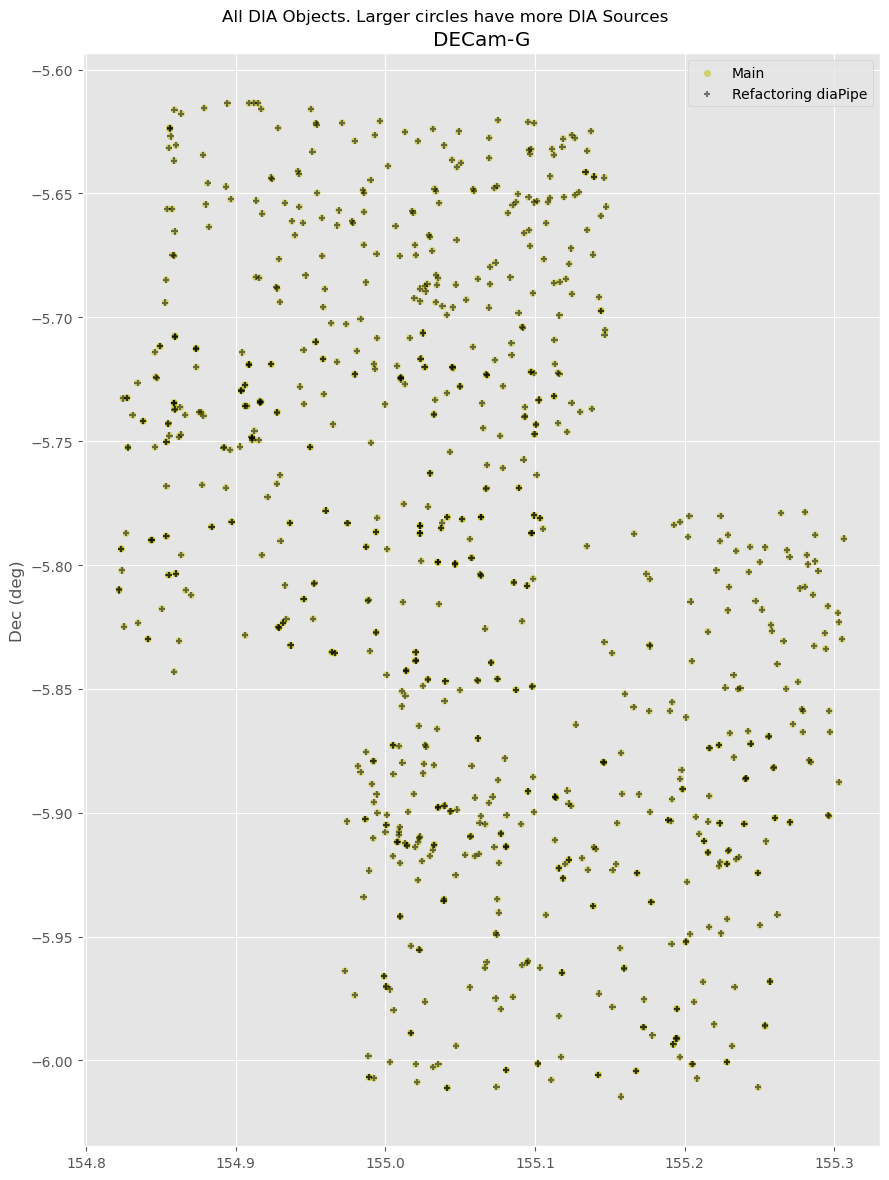

In [43]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run]):
    goodFilter = (run_dict['robjTable']['nDiaSources'] > nSrc)
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    ax.scatter(run_dict['robjTable'].loc[goodFilter, 'ra'],
               run_dict['robjTable'].loc[goodFilter, 'dec'],
               s=run_dict['robjTable'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
plt.tight_layout()

## 7. Number of "Good" DiaSources per Detector

In [44]:
# GOAL: count number of diaSources per detector, via the diaSource table
def goodDetectorSources(associationPath, plotTitle):
    pp_apdb = apdb.ApdbSqliteQuery(associationPath, instrument=instrument)
    DiaSource = pp_apdb._tables["DiaSource"]
    
    diaSource_count_query = select(func.count("*")).select_from(DiaSource)
    good_diaSource_count_query = select(func.count("*")).select_from(DiaSource). \
        where((DiaSource.c.pixelFlags_edge==False) & (DiaSource.c.pixelFlags_bad==False) & (DiaSource.c.pixelFlags_suspect==False)
        & (DiaSource.c.pixelFlags_interpolatedCenter==False) & (DiaSource.c.pixelFlags_saturatedCenter==False))
    row_print_query = DiaSource.select().where(DiaSource.c.diaObjectId > 100).limit(5)
    
    unique_dataId_query = select(DiaSource.c.visit, DiaSource.c.detector, func.count("*")).\
        where((DiaSource.c.pixelFlags_edge==False) & (DiaSource.c.pixelFlags_bad==False) & (DiaSource.c.pixelFlags_suspect==False)
        & (DiaSource.c.pixelFlags_interpolatedCenter==False) & (DiaSource.c.pixelFlags_saturatedCenter==False)).\
        group_by(DiaSource.c.visit, DiaSource.c.detector)
    
    with pp_apdb.connection as conn:
        nDiaSources = conn.execute(diaSource_count_query).fetchall()
        nGoodDiaSources = conn.execute(good_diaSource_count_query).fetchall()
        fiveRows = conn.execute(row_print_query).fetchall()
        nUniqueDataIds = conn.execute(unique_dataId_query).fetchall()
        print(f'{nDiaSources[0][0]} total diaSources')
        print(f'{nGoodDiaSources[0][0]} of those are "good" diaSources')
        print(f'Here are the first 20 unique (visit, detector) diaSource counts:')
        print(nUniqueDataIds[0:20])
    
    df = pd.DataFrame(nUniqueDataIds)
    
    plt.figure()
    plt.hist(df.count_1, log=True, color='cornflowerblue', alpha=0.85)
    plt.xlabel('Number of "good" diaSources per detector')
    plt.ylabel('Count')
    plt.title(f'{plotTitle}')
    plt.show()

845 total diaSources
795 of those are "good" diaSources
Here are the first 20 unique (visit, detector) diaSource counts:
[(411371, 56, 235), (411371, 60, 182), (411420, 5, 143), (411420, 10, 133), (419802, 5, 54), (419802, 10, 48)]


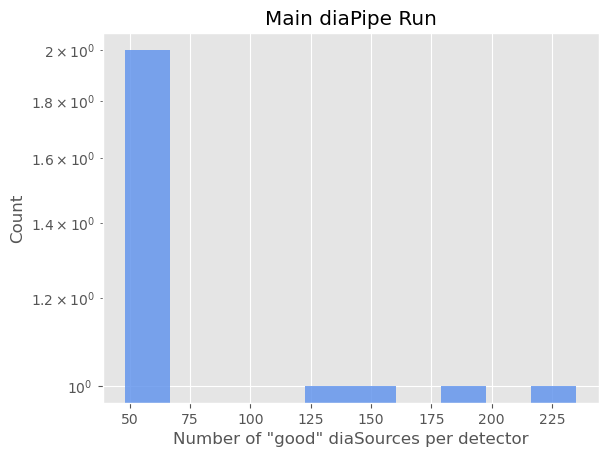

In [45]:
goodDetectorSources('/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11/association.db', 'Main diaPipe Run')

845 total diaSources
795 of those are "good" diaSources
Here are the first 20 unique (visit, detector) diaSource counts:
[(411371, 56, 235), (411371, 60, 182), (411420, 5, 143), (411420, 10, 133), (419802, 5, 54), (419802, 10, 48)]


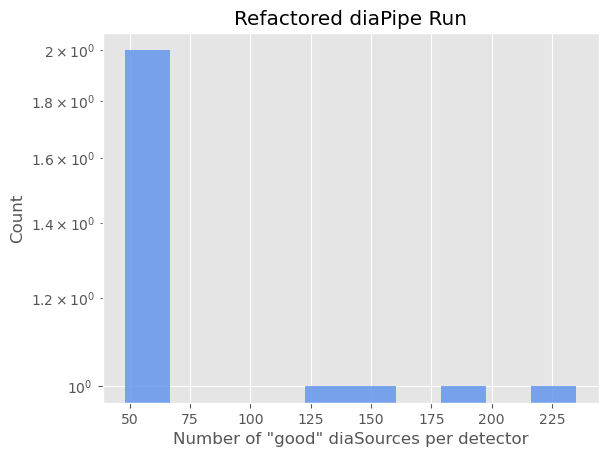

In [46]:
goodDetectorSources('/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_09_11-DM45218/association.db', 'Refactored diaPipe Run')